<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week08-workshop-2/ibm_attrition_nb_naive_bayes_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes and Logistic Regression with GridSearchCV on IBM Attrition Dataset
This notebook demonstrates how to train a classification model using both Naive Bayes and Logistic Regression on the same GridSearchCV pipeline. It includes:
- Data preprocessing
- Model training with `GridSearchCV`
- Performance evaluation using a confusion matrix and classification report.
- https://inseaddataanalytics.github.io/INSEADAnalytics/groupprojects/January2018FBL/IBM_Attrition_VSS.html



In [17]:
# Install necessary libraries
!pip install pandas scikit-learn matplotlib seaborn


In [ ]:
!pip install wandb

In [28]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt


In [32]:
# Load the IBM attrition dataset
df = pd.read_csv('https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/refs/heads/master/Dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Preview the data
#print(df.head())
print(df.shape)

# Convert 'Attrition' target to numerical: Yes -> 1, No -> 0
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop target from features
X = df.drop(columns=['Attrition'])
y = df['Attrition']

# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)
#print(X.head())

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
#print(X_train.shape)


(1470, 35)


In [46]:
X.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
  

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Create a pipeline with both Naive Bayes and Logistic Regression
pipe = Pipeline([
    ('model', GaussianNB())  # Placeholder, will be replaced during grid search
])

# Define the parameter grid for both models
param_grid = [
    {'model': [GaussianNB()]},  # No hyperparameters to tune for GaussianNB
    {'model': [LogisticRegression(max_iter=1000)],
     'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength for LogisticRegression
     'model__solver':  ['lbfgs', 'liblinear'] #,'newton-cg', 'newton-cholesky', 'sag', 'saga'],
     #'model__penalty': ['l1', 'l2', 'elasticnet'],
     #'model__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
     }
]

# Perform GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=7)
grid_search.fit(X_train, y_train)

# Best model and its parameters
print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)
#print(y_pred)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probability of positive class
#print(y_pred_proba)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

# AUC
roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test Set Accuracy: {roc_auc_score}")


In [34]:
run = wandb.init(project='Attritition ML', name="classification")

wandb: Currently logged in as: ekaratnida (ekaratnida-nida). Use `wandb login --relogin` to force relogin


In [41]:
wandb.sklearn.plot_learning_curve(grid_search.best_estimator_, X_train, y_train)


In [ ]:
wandb.sklearn.plot_classifier(grid_search.best_estimator_,
                              X_train, X_test,
                              y_train, y_test,
                              y_pred, y_pred_proba,
                              is_binary=True,
                              labels=[0, 1],
                              model_name='logistic regression') #grid_search.best_estimator_)

wandb.finish()

In [ ]:
print(y_pred)
print(y_pred_proba)

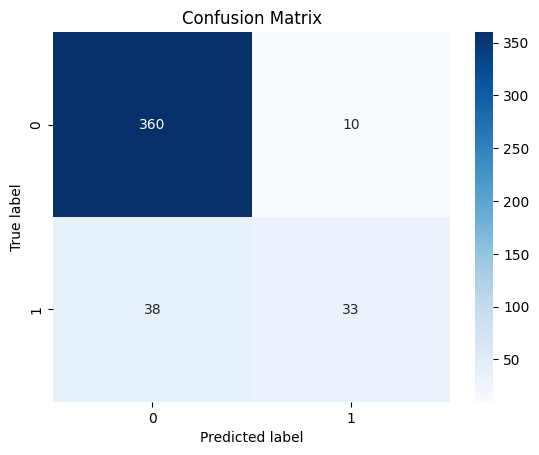

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       370
           1       0.77      0.46      0.58        71

    accuracy                           0.89       441
   macro avg       0.84      0.72      0.76       441
weighted avg       0.88      0.89      0.88       441



In [23]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))




ROC AUC=0.814


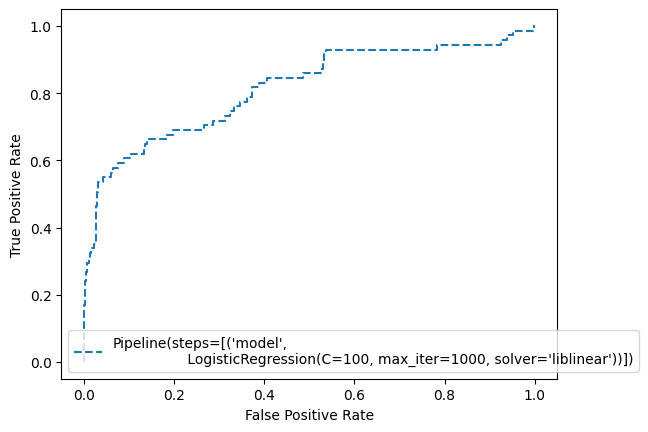

In [24]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate scores
ns_auc = roc_auc_score(y_test, y_pred_proba)

# summarize scores
print('ROC AUC=%.3f' % (ns_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred_proba)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label=grid_search.best_estimator_)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [ ]:
!pip install shap

In [45]:
import shap

In [50]:
explainer = shap.Explainer(
                           grid_search.best_estimator_.named_steps['model'],
                           X_train,
                           feature_names=X_train.columns.tolist()
                           )
shap_values = explainer(X_test)

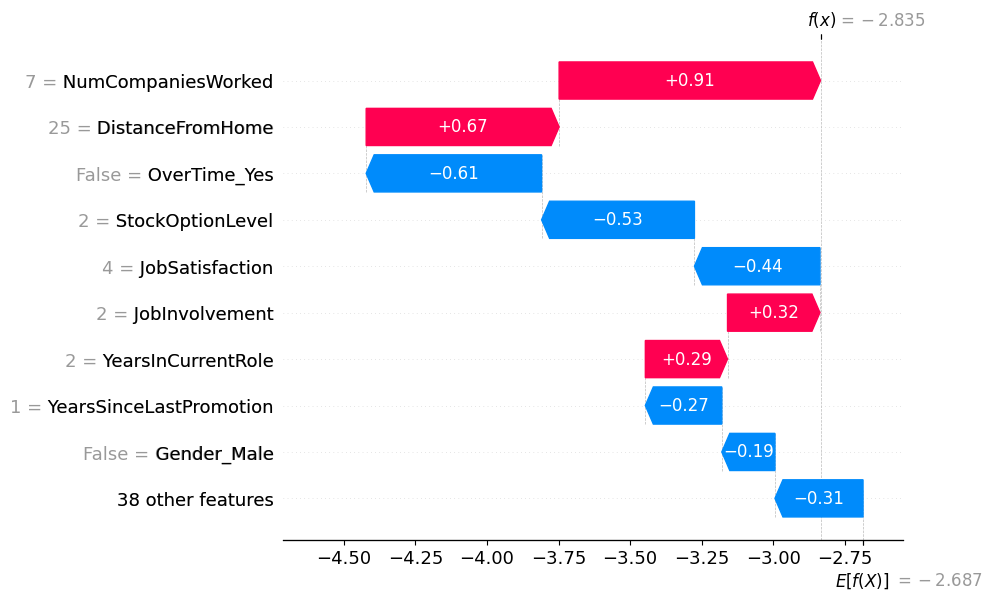

In [59]:
shap.plots.waterfall(shap_values[1])

In [65]:
shap.initjs()
shap.plots.force(shap_values[0])
